In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import multiprocessing as mp
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib as mpl
import warnings

from cycler import cycler
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from astropy.convolution import convolve
from glob import glob
from lmfit import Model
from lmfit.printfuncs import report_fit
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from specutils.manipulation import LinearInterpolatedResampler
from specutils import Spectrum1D

#for warnings
from uncertainties import UFloat
from astropy.utils.exceptions import AstropyDeprecationWarning

### Plott formatting

In [51]:
# clrs = sns.color_palette('Set1')
# clrs[5] = (255/255, 200/255, 80/255)
# colors = cycler('color', list(clrs.as_hex()))
# mpl.rc('font', family='serif')
# #mpl.rc('text', usetex=True)

# plt.rc('axes', axisbelow=True, 
#        grid=False, prop_cycle=colors)
# plt.rc('xtick', direction='in')
# plt.rc('ytick', direction='in')
# plt.rcParams['figure.dpi'] = 75

## Functions

In [2]:
def get_asnfilenames(fuvFile, datadir):
    """
    A function to fetch the right association filenames for convolution based on fits header information

    Parameters:
    fuvFile: a FITS HDU file with a SCI header
    datadir: the directory in which the association files are stored

    Returns:
    disptab_file (str): the name of the associated dispersion table file
    lsf_file (str): the name of the associated line spread function file based on 
                    filter, lifetime position, and central wavelength
    """
    fuvHeader0 = fits.getheader(fuvFile, ext=0)

    disptab_file = fuvHeader0['DISPTAB'].split("$")[1]
    grating = fuvHeader0['OPT_ELEM']
    cenwave = fuvHeader0['CENWAVE']
    lpPos = fuvHeader0['LIFE_ADJ']
    lsf_file = os.path.join(datadir,f"aa_LSFTable_{grating}_{cenwave}_LP{lpPos}_cn.dat")
    disptab_file = os.path.join(datadir,disptab_file)
    return lsf_file, disptab_file

def get_disp_params(disptab, cenwave, filt, segment):
    data = disp_df.loc[disptab]
    wh_disp = np.where(
                (data["CENWAVE"] == cenwave)
                & (data["SEGMENT"] == segment)
                & (data["OPT_ELEM"] == filt)
            )[0]# 0 is needed as this returns nested list [[arr]]
    disp_coeff = data['COEFF'][wh_disp][0]# 0 is needed as this returns nested list [[arr]]
    d_tv03 = data["D_TV03"][wh_disp]  # Offset from WCA to PSA in Thermal Vac. 2003 data
    d_orbit = data["D"][wh_disp]  # Current offset from WCA to PSA
    delta_d = d_tv03 - d_orbit
    disp_coeff = disp_coeff-delta_d
    return disp_coeff
    
def redefine_lsf(lsf_file, disptab, cenwave, filter, segment):
    """
    Helper function to convolve_lsf(). Converts the LSF kernels in the LSF file from a fn(pixel) -> fn(λ)\
    which can then be used by convolve_lsf() and re-bins the kernels.
    Parameters:
    lsf_file (str): path to your LSF file
    cenwave (str): Cenwave for calculation of dispersion relationship
    disptab (str): path to your DISPTAB file
    
    Returns:
    new_lsf (numpy.ndarray): Remapped LSF kernels.
    new_w (numpy.ndarray): New LSF kernel's LSF wavelengths.
    step (float): first order coefficient of the FUVA dispersion relationship; proxy for Δλ/Δpixel.
    """

    # Read in the dispersion relationship here for the segments
    if segment == 'FUVB':
        if (cenwave != 1105) & (cenwave != 800):
            disp_coeff = get_disp_params(disptab, cenwave, filter, segment)
    else:
        disp_coeff = get_disp_params(disptab, cenwave, filter, segment)

    # Get the step size info from the FUVA 1st order dispersion coefficient
    step = disp_coeff[1]

    # Read in the lsf file
    data = lsf_df.loc[lsf_file]
    lsf=data['lsf']
    pix=data['pix']
    w=data['w']

    # take median spacing between original LSF kernels
    deltaw = np.median(np.diff(w))

    if (deltaw < len(pix) * step * 2):  # resamples if the spacing of the original LSF wvlns is too narrow
        # this is all a set up of the bins we want to use
        # The wvln difference between kernels of the new LSF should be about twice their width
        new_deltaw = int(len(pix) * step * 2.0)  
        new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  # nw = number of LSF wavelengths
        
        new_w = min(w) + np.arange(new_nw) * new_deltaw  # new version of lsf_wvlns
        
        # populating the lsf with the proper bins
        new_lsf = np.zeros((len(pix), new_nw))  # empty 2-D array to populate

        for i, current_w in enumerate(new_w):
            dist = abs(current_w - w)  # Find closest original LSF wavelength to new LSF wavelength
            lsf_index = np.argmin(dist)
            orig_lsf_wvln_key = lsf.keys()[lsf_index]  # column name corresponding to closest orig LSF wvln
            new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  # assign new LSF wvln the kernel of the closest original lsf wvln
    else:
        new_lsf = lsf
        new_w = w
    return new_lsf, new_w, step

def convolve_lsf(wavelength, flux, lsf_file, disptab, cenwave, filter, segment, verbose=False):

    """
    Main function; Convolves an input spectrum - i.e. template or STIS spectrum - with the COS LSF.
    Parameters:
    wavelength (list or array): Wavelengths of the spectrum to convolve.
    flux (list or array): Fluxes or intensities of the spectrum to convolve.
    cenwave (str): Cenwave for calculation of dispersion relationship
    lsf_file (str): Path to your LSF file
    disptab (str): Path to your DISPTAB file
    Returns:
    wave_cos (numpy.ndarray): Wavelengths of convolved spectrum.!Different length from input wvln
    final_spec (numpy.ndarray): New LSF kernel's LSF wavelengths.!Different length from input spec
    """
    # First calls redefine to get all LSF kernels transformed to the right wavelength scales
    new_lsf, new_w, step = redefine_lsf(lsf_file, disptab, cenwave, filter, segment)

    # sets up new wavelength scale used in the convolution
    nstep = round((max(wavelength) - min(wavelength)) / step) - 1
    wave_cos = min(wavelength) + np.arange(nstep) * step #construct the goal LSF wavelength to transform the LSF flux to

    # interpolate input spectrum onto the LSF's wavelength resolution
    interp_func = interp1d(wavelength, flux)  # builds up interpolated function from input spectrum
    current_flux = interp_func(wave_cos)  # lower res version of the same input spectrum
    final_flux = interp_func(wave_cos)  # initialize convolution spectrum

    peak_wavelength = wavelength[np.argmax(flux)]
    #===============THIS=====================
    #best_kernel_idx = np.argmin(np.abs(new_w-peak_wavelength))
    #current_lsf = new_lsf[:, best_kernel_idx]

    #===========OR THAT========================
    #interpolate nearest LSF kernels to emission line wavelength space
    if peak_wavelength <= new_w[0]:
        current_lsf = new_lsf[:, 0]
    elif peak_wavelength >= new_w[-1]:
        current_lsf = new_lsf[:, -1]
    else:
        lower_idx = np.searchsorted(new_w, peak_wavelength) - 1
        upper_idx = lower_idx + 1

        wl_low = new_w[lower_idx]
        wl_high = new_w[upper_idx]
        lsf_low = new_lsf[:, lower_idx]
        lsf_high = new_lsf[:, upper_idx]

        # Linear interpolation weight
        w = (peak_wavelength - wl_low) / (wl_high - wl_low)
        interp_lsf = (1 - w) * lsf_low + w * lsf_high
        current_lsf = interp_lsf/np.sum(interp_lsf)

    #=======PLOTTING FOR DIAGNOSTICS=================

    # low_lambda_axis  = wl_low  + np.arange(-lsf_low.size  // 2, lsf_low.size  // 2) * step
    # high_lambda_axis = wl_high + np.arange(-lsf_high.size // 2, lsf_high.size // 2) * step
    # lambda_axis      = peak_wavelength + np.arange(-current_lsf.size // 2, current_lsf.size // 2) * step

    # low_lsf_shifted  = (lsf_low  / lsf_low.max())  * spec_cos.max()
    # high_lsf_shifted = (lsf_high / lsf_high.max()) * spec_cos.max()
    # lsf_shifted      = (current_lsf      / current_lsf.max())      * spec_cos.max()

    # plt.clf()
    # plt.plot(wave_cos, spec_cos, label='Interpolated Spectrum (spec_cos)')
    # plt.plot(low_lambda_axis, low_lsf_shifted, '--', label=f'LSF at {wl_low:.1f} A')
    # plt.plot(high_lambda_axis, high_lsf_shifted, '--', label=f'LSF at {wl_high:.1f} A')
    # plt.plot(lambda_axis, lsf_shifted, '--', label='Interpolated LSF')
    # plt.legend()
    # plt.show()

    final_flux = convolve(
                    current_flux,
                    current_lsf,  # Applies the actual convolution
                    boundary="extend",
                    normalize_kernel=True,
                )
    #one final interpolation to make arrays the same length as the input arrays
    xnew = np.linspace(min(wave_cos), max(wave_cos), len(wavelength))
    final_interpfunc = interp1d(wave_cos, final_flux)
    
    conv_flux = final_interpfunc(xnew)
    return xnew, conv_flux

def single_bootstrap(args):
    warnings.filterwarnings(
        "ignore",
        message="Using UFloat objects with std_dev==0 may give unexpected results.",
        category=UserWarning,
    )
    warnings.simplefilter('ignore', AstropyDeprecationWarning)

    x, gaussflux, model, split_resid, fluxerr, param_kwargs, method, verbose, conv_args= args
        
    resample_idx = np.random.randint(0, len(split_resid), size=len(split_resid))
    resample = np.array(split_resid)[resample_idx]
    #concatenate blocks and cut to length of gaussflux
    resample = np.ravel(resample)[:len(gaussflux)]
    #add to gaussflux
    resampled_y = gaussflux+np.sqrt((resample**2+fluxerr**2)) # Resampled signal
    peak = np.max(resampled_y)
    Param = model.make_params(**param_kwargs)
    # Pick correct parameter set
    eps = 8e-13
    if len(param_kwargs) == 7:
        Param['amp1'].set(min=0.3*peak, max=max(2*peak, eps))
        Param['amp2'].set(min=0.2*peak, max=max(peak, 0.8*eps)) #just need amp2 to be smaller
        Param['sig1'].set(min=0.2*Param['sig1'].value, max=2*Param['sig1'].value)
        Param['sig2'].set(min=0.3*Param['sig2'].value, max=3*Param['sig2'].value)
        Param['cen1'].set(min=Param['cen1'].value-0.5, max=Param['cen1'].value+0.5)
        Param['cen2'].set(min=Param['cen2'].value-0.5, max=Param['cen2'].value+0.5)
        Param['bgl'].set(min=0.6*Param['bgl'].value, max=1e-12)
    elif len(param_kwargs) == 4:
        Param['amp'].set(min=0.5*Param['amp'], max=max(peak*1.2, eps))
        Param['sig'].set(min=0.5, max=3) #1 wavelength ~ 200km/s radial velocity
        Param['cen'].set(min=np.min(x), max=Param['cen'].value+3)
        Param['bgl'].set(min=Param['bgl'].value*0.8, max=1e-10)
    else:
        raise ValueError('Please use either the single or double Gauss model.')

    # Fit model
    lsf_file, disptab, cenwave, filt, segment = conv_args
    boot_result = model.fit(
        resampled_y,
        Param,
        x=x,
        weights=1/resample,
        scale_covar=False,
        method=method,
        lsf_file=lsf_file, 
        disptab=disptab, 
        cenwave=cenwave, 
        filt=filt, 
        segment=segment
    )
    if verbose:
        print(boot_result.covar)
    return [boot_result.params[name].value for name in model.param_names]


In [ ]:
class spectrum():
    def __init__(self, files, linelist_file, dataDir, convolve=False):
    
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = pd.read_csv(linelist_file, skiprows=2)
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
    
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)

            LSF_file, disptab_file = get_asnfilenames(fuvFile=file, datadir=dataDir)
            cenwave = INST_head['CENWAVE']

            if "cspec" in file:
                date = SCI_head['DATE-BEG'][:10]
                segments = None
            elif "x1dsum" in file:
                date = SCI_head['DATE-OBS'] 
                instrument = INST_head['INSTRUME']
                if len(spectrum_x1d['WAVELENGTH']):
                    segmenta = [spectrum_x1d['WAVELENGTH'][spectrum_x1d['SEGMENT']=='FUVA'].min(), spectrum_x1d['WAVELENGTH'][spectrum_x1d['SEGMENT']=='FUVA'].max()]
                    segmentb = [spectrum_x1d['WAVELENGTH'][spectrum_x1d['SEGMENT']=='FUVB'].min(), spectrum_x1d['WAVELENGTH'][spectrum_x1d['SEGMENT']=='FUVB'].max()]
                    segments = [segmenta, segmentb]
                else:
                    segments = None
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header

            x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            self.fileInfo_keys = ['filename', 'obsdate', 'instrument', 'filter', 'dispfile', 'LSFfile', 'cenwave']
            self.specInfo_keys = ['wavelength', 'flux', 'fluxerr', 'velocity', 'segment']
            self.lineInfo_keys = ['H2line_idx', "labline", "transition_prob"]
            df_data = {'filename':file, 
                    'obsdate':date,
                    'instrument':instrument, 
                    'filter':instrument_filter,
                    'dispfile':disptab_file,
                    'LSFfile': LSF_file,
                    'cenwave':cenwave,
                    'wavelength':x1d_wavelength*self.wavelength_units, 
                    'flux': x1d_flux*self.flux_units, 
                    'fluxerr':x1d_fluxerr*self.flux_units,
                    'segment': segments}
            rows.append(pd.Series(df_data))
            
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)
        self.spec_df['obsdate'] = self.spec_df['obsdate'].astype(str)
    
    def mask_df(self, df, mask_dict):
        columns = mask_dict.keys()
        values = mask_dict.values()
        mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, values)])
        filtered = df[mask]
        return filtered

    def coaddwave(self, df, columns=['obsdate']):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - df: The dataframe to use for co-adding. Must contain 'wavelength', 
              'flux', and 'fluxerr' columns at least. If using velocity_space, must contain 'rest_wavelength' column.
        - columns: the columns of unique combinations to apply coadding to.

        Returns:
        - coadded_spectrum: spectrum dataframe
        """

        drop_indices = []
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]

            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]

            resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
            wavelengths = group['wavelength'].values
            fluxes = group['flux'].values
            fluxerrs = group['fluxerr'].values
            
            template_axis = wavelengths[0][np.argsort(wavelengths[0])]
            template_flux = fluxes[0][np.argsort(wavelengths[0])]
            template_fluxerr = fluxerrs[0][np.argsort(wavelengths[0])]
            
            coadded = Spectrum1D(
                flux=template_flux,
                spectral_axis=template_axis,
                uncertainty=StdDevUncertainty(template_fluxerr)
            )

            for i in np.arange(0, len(wavelengths)):
                x = wavelengths[i]
                flux = fluxes[i]
                err = fluxerrs[i]
                sort_idx = np.argsort(x)
                spec = Spectrum1D(spectral_axis=x[sort_idx], 
                                    flux=flux[sort_idx], 
                                    uncertainty=StdDevUncertainty(err[sort_idx])
                                )
                
                spec_resampled = resampler(spec, coadded.spectral_axis)
                coadded += spec_resampled
            
            first_index = group.index[0]
            df.at[first_index, 'wavelength'] = coadded.wavelength
            df.at[first_index, 'flux'] = coadded.flux
            df.at[first_index, 'fluxerr'] = coadded.uncertainty.quantity.to(self.flux_units)
            drop_indices.extend(group.index[1:])
        
        df.drop(drop_indices, inplace=True)
        df.reset_index(inplace=True, drop=True)
        #return stacked_df

    def H2lines_fromspectrum(self, df):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = pd.Series([None] * len(df), dtype=object)
        df["[nu', J']"] = pd.Series([None] * len(df), dtype=object)
        df["labline"] = pd.Series([None] * len(df), dtype=object)
        df["transition_prob"] = pd.Series([None] * len(df), dtype=object)
        for i, row in df.iterrows():            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = [] #wavelength array index
            nu_J = [] #transition of line from linelist
            lab_lines = [] #lab wavelength of emission line from linelist
            transition_prob = []

            for il, l in enumerate(self.linelist['lab_lambda'].values):
                wavelength = row['wavelength']/u.AA
                diffs = np.abs(wavelength-l)
                mask = diffs <= 0.2
                if np.any(mask):
                    min_idx = np.argmin(diffs)
                    emission_table_idx.append(min_idx)
                    nu_J.append(self.linelist.loc[il, '[nu\', J\']'])
                    transition_prob.append(self.linelist.loc[il, 'transition_prob'])
                    lab_lines.append(l)
            df.at[i, 'H2line_idx'] = np.array(emission_table_idx)
            df.at[i, "[nu', J']"] = nu_J
            df.at[i, 'labline'] = lab_lines
            df.at[i, 'transition_prob'] = transition_prob
        return df

    def radial_velocity(self, wavelengths, labline):
        velocity = (wavelengths - labline*u.AA)/(labline*u.AA) * const.c.to(u.km/u.s)
        return velocity
    
    def get_lines(self, df):
        line_width = 150 #150 points on either side of the central line
        transitions = set(self.linelist["[nu\', J\']"])
        line_keys = self.fileInfo_keys+self.specInfo_keys+self.lineInfo_keys
        line_dict = {key: [] for key in line_keys}
        line_dict['transition'] = []
        for target_nuJ in transitions:
            for _, row in df.iterrows():
                if target_nuJ in row["[nu', J']"]:
                    nuJ_array = np.atleast_1d(row["[nu', J']"])
                    h2_idx_array = np.atleast_1d(row['H2line_idx'])
                    targ_idx = np.flatnonzero(nuJ_array == target_nuJ)
                    line_idx = h2_idx_array[targ_idx] #the index of the H2 line of interest in every wavelength coadded spectrum

                    for i, l in enumerate(line_idx):
                        start = max(0, l - line_width)
                        end = min(len(row['wavelength']), l + line_width)  
                        #Spectrum information
                        waves = row['wavelength'][start:end]
                        line_dict['wavelength'].append(waves)
                        line_dict['flux'].append(row['flux'][start:end])
                        line_dict['fluxerr'].append(row['fluxerr'][start:end])
                        velocity = self.radial_velocity(waves, row['labline'][targ_idx[i]])
                        line_dict['velocity'].append(velocity)
                        if row['segment']:
                            if row['segment'][0][0] <= row['labline'][targ_idx[i]] <= row['segment'][0][1]:
                                line_dict['segment'].append('FUVA')
                            elif row['segment'][1][0] <= row['labline'][targ_idx[i]] <= row['segment'][1][1]:
                                line_dict['segment'].append('FUVB')
                            else:
                                line_dict['segment'].append(None)
                        #File information
                        for key in self.fileInfo_keys:
                            line_dict[key].append(row[key])
                        #Line information
                        line_dict['transition'].append(target_nuJ)
                        for key in self.lineInfo_keys:    
                            line_dict[key].append(np.array(row[key])[targ_idx[i]])
        line_df = pd.DataFrame(line_dict)
        return line_df
    
    def coaddvel(self, prog_df, columns=['transition', 'obsdate']):
        #Calculate the velocity distribution fot every fit
        df = prog_df.copy()
        for i, row in df.iterrows():
            wavelengths = row['conv_wavelength']
            labline = row['labline']
            velocity = self.radial_velocity(wavelengths, labline)
            df.at[i, 'velocity'] = velocity

        #group df by columns to coadd all lines in a transition
        combinations = df[columns].drop_duplicates()
        df['single_coadded_flux'] = pd.Series([None] * len(df), dtype=object)
        df['single_coadded_fluxerr'] = pd.Series([None] * len(df), dtype=object)
        df['double_coadded_flux'] = pd.Series([None] * len(df), dtype=object)
        df['double_coadded_fluxerr'] = pd.Series([None] * len(df), dtype=object)
        df['coadded_velocity'] = pd.Series([None] * len(df), dtype=object)
        drop_indices = []
        for i, group_row in combinations.iterrows():
            # Filter the group to get a set of lines from one date and transition
            mask_dict = {col: group_row[col] for col in columns}
            group = self.mask_df(df, mask_dict)

            #Create a template velocity to interpolate on to
            #covers the full range of velocities in the emission lines
            vmin = min([min(v) for v in group['velocity']])
            vmax = max([max(v) for v in group['velocity']])
            templatev = np.linspace(vmin, vmax, 300)
            
            #initialize coadding arrays
            coadded_singleflux = np.zeros_like(templatev.value)*self.flux_units
            coadd_error = np.zeros_like(templatev.value)*(self.flux_units**2)

            coadded_doubleflux = np.zeros_like(templatev.value)*self.flux_units
            coadd_2error = np.zeros_like(templatev.value)*self.flux_units**2


            for _, row in group.iterrows():
                #Coadd both Gaussians
                ygauss = row['gauss_flux']
                ygausserr = row['gauss_fluxerr']

                y2gauss = row['double_gauss_flux']
                y2gausserr = row['double_gauss_fluxerr']

                vel = row['velocity']

                #Most lines are blue-shifted a little
                #when coadded, they are not going to look gaussian anymore
                resampled_singleflux = np.interp(templatev, vel, ygauss)
                resampled_singlefluxerr = np.interp(templatev, vel, ygausserr)
                resampled_doubleflux = np.interp(templatev, vel, y2gauss)
                resampled_doublefluxerr = np.interp(templatev, vel, y2gausserr)
                
                coadded_singleflux += resampled_singleflux
                coadd_error += (resampled_singlefluxerr)**2
                coadded_doubleflux += resampled_doubleflux
                coadd_2error += (resampled_doublefluxerr)**2

            N = len(group)
            coadded_singleflux /= N
            coadded_singleerror = np.sqrt(coadd_error)/N

            coadded_doubleflux /= N
            coadd_2error = np.sqrt(coadd_2error)/N

            first_index = group.index[0]
            # All the first index properties are inherited and the rest is dropped
            df.at[first_index, 'single_coadded_flux'] = coadded_singleflux
            df.at[first_index, 'single_coadded_fluxerr'] = coadded_singleerror
            df.at[first_index, 'double_coadded_flux'] = coadded_doubleflux
            df.at[first_index, 'double_coadded_fluxerr'] = coadd_2error
            df.at[first_index, 'coadded_velocity'] = templatev
            drop_indices.extend(group.index[1:])

        df.drop(drop_indices, inplace=True)
        df.drop(['conv_wavelength', 'gauss_flux','gauss_fluxerr', 'double_gauss_flux', 'double_gauss_fluxerr', 'wavelength', 'flux', 'fluxerr', 'velocity'], axis=1, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df

In [ ]:
class ModelFitting():
    def __init__(self, df, mask_dict, verbose=False):
        #operate largely without units
        df['BIC1'] = pd.Series([None] * len(df), dtype=object)
        df['params1'] = pd.Series([None] * len(df), dtype=object)
        df['BIC2'] = pd.Series([None] * len(df), dtype=object)
        df['params2'] = pd.Series([None] * len(df), dtype=object)
        self.df = df
        self.mask_dict = mask_dict
        self.lineModel = Model(self.gaussian_conv, independent_vars=['x', 'lsf_file', 'disptab', 'cenwave', 'filt', 'segment'])
        self.doubleLineModel = Model(self.double_gauss_conv, independent_vars=['x', 'lsf_file', 'disptab', 'cenwave', 'filt', 'segment'])
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.verbose = verbose

    def mask_contamination(self, labline, mask_dict):
        mask_idx = mask_dict[labline]
        if isinstance(mask_idx, list):
            mask=np.ones(300, dtype=bool)
            mask[mask_idx[0]:mask_idx[1]] = False
            return mask
        else:
            mask=np.zeros(300, dtype=bool)
            mask[mask_idx:] = True
            return mask
        
    def gaussian(self, x, amp, sig, cen, bgl):
        x = np.array(x)
        y = amp * np.exp(-((x - cen)**2.0)/(2.0 * (sig**2.0))) + bgl
        return y

    def gaussian_conv(self, x, amp, sig, cen, bgl, lsf_file, disptab, cenwave, filt, segment):
        x = np.array(x)
        y = amp * np.exp(-((x - cen)**2.0)/(2.0 * (sig**2.0))) + bgl
        
        _, y_conv = convolve_lsf(x, y, lsf_file, disptab, cenwave, filt, segment)
        
        return y_conv

    def double_gauss_conv(self, x, amp1, sig1, cen1, amp2, sig2, cen2, bgl, lsf_file, disptab, cenwave, filt, segment):
        y = self.gaussian(x, amp1, sig1, cen1, 0) + self.gaussian(x, amp2, sig2, cen2, 0) + bgl
        _, y_conv = convolve_lsf(x, y, lsf_file, disptab, cenwave, filt, segment, self.verbose)
        return y_conv
            
    def gauss_err(self, x, y, yerr, params, paramerrs, cov, conv_args):
        """
        Calculate propagated error for a Gaussian model with background.
        Parameters assumed: [amp, sig, cen, bgl]
        """
        lsf_file, disptab, cenwave, filt, segment = conv_args

        amp, sig, cen, _ = [params[k] for k in self.lineModel.param_names]
        err_vals = [paramerrs[k] for k in self.lineModel.param_names]
        amp_err, sig_err, cen_err, bgl_err = err_vals
        
        # Compute the Gaussian (without background)
        gauss = amp * np.exp(-(x - cen)**2 / (2*sig**2))
        
        # Compute partial derivatives
        dfdA = np.exp(-(x - cen)**2 / (2*sig**2))
        dfdmu = gauss * np.abs(x - cen) / (sig**2)
        dfdsig = gauss * ((x - cen)**2 / (sig**3))
        dfdbgl = np.ones_like(x)

        if self.verbose:
            dfdA_term = (dfdA * amp_err)**2
            dfdmu_term = (dfdmu * cen_err)**2
            dfdsig_term = (dfdsig * sig_err)**2
            dfdbgl_term = (dfdbgl * bgl_err)**2

            plt.plot(x, np.sqrt(dfdA_term), label="amp contribution")
            plt.plot(x, np.sqrt(dfdmu_term), label="cen contribution")
            plt.plot(x, np.sqrt(dfdsig_term), label="sigma contribution")
            plt.plot(x, np.sqrt(dfdbgl_term), label="background contribution")
            plt.legend()
            plt.show()

        # Propagate uncertainties (assuming parameters uncorrelated)
        if cov is not None:
            J = np.column_stack([dfdA, dfdsig, dfdmu, dfdbgl])
            cov_matrix = np.asarray(cov)
            spec_var = np.einsum('ij,jk,ik->i', J, cov_matrix, J)
            specerr = np.sqrt(spec_var)

        elif all(v is not None for v in err_vals):
            # Assume uncorrelated parameters
            specerr = np.sqrt((dfdA * amp_err)**2 +
                            (dfdmu * cen_err)**2 +
                            (dfdsig * sig_err)**2 +
                            (dfdbgl * bgl_err)**2)
        else:
            if self.verbose:
                print('Bootstrapping errors')
            _, specerr = self.bootstrap_err(x, self.lineModel, y, yerr, params, conv_args)
        
        xconv, conv_err = convolve_lsf(x, specerr, lsf_file, disptab, cenwave, filt, segment)

        return xconv, conv_err

    def double_gauss_err(self, x, y, yerr, params, paramerrs, cov, conv_args):
        """
        Calculate propagated error for a double Gaussian with background.
        Parameters: [amp1, sig1, cen1, amp2, sig2, cen2, bgl]
        """
        lsf_file, disptab, cenwave, filt, segment = conv_args

        # Extract parameter values and errors
        pnames = self.doubleLineModel.param_names
        vals = [params[k] for k in pnames]
        err_vals = [paramerrs[k] for k in pnames]
        amp1_err, sig1_err, cen1_err, amp2_err, sig2_err, cen2_err, bgl_err = err_vals
        amp1, sig1, cen1, amp2, sig2, cen2, _ = vals

        # Compute the Gaussians without background
        g1 = amp1 * np.exp(-(x - cen1)**2 / (2*sig1**2))
        g2 = amp2 * np.exp(-(x - cen2)**2 / (2*sig2**2))
        
        # Partial derivatives for Gaussian 1
        dfdA1 = np.exp(-(x - cen1)**2 / (2*sig1**2))
        dfdmu1 = g1 * (x - cen1) / (sig1**2)
        dfdsig1 = g1 * ((x - cen1)**2 / (sig1**3))
        
        # Partial derivatives for Gaussian 2
        dfdA2 = np.exp(-(x - cen2)**2 / (2*sig2**2))
        dfdmu2 = g2 * (x - cen2) / (sig2**2)
        dfdsig2 = g2 * ((x - cen2)**2 / (sig2**3))
        
        # Background derivative
        dfdbgl = np.ones_like(x)
        
        # Combine propagated errors
        if cov is not None:
            J = np.column_stack([dfdA1, dfdsig1, dfdmu1, dfdA2, dfdsig2, dfdmu2, dfdbgl])
            
            cov_matrix = np.asarray(cov)
            if cov_matrix.shape != (7, 7):
                raise ValueError(f"Covariance matrix shape {cov_matrix.shape} is not (4,4)")
            
            spec_var = np.einsum('ij,jk,ik->i', J, cov, J)
            specerr = np.sqrt(spec_var)
        elif all(v is not None for v in err_vals):
            #Assuming parameters uncorrelated
            specerr = np.sqrt(
                (dfdA1 * amp1_err)**2 +
                (dfdmu1 * cen1_err)**2 +
                (dfdsig1 * sig1_err)**2 +
                (dfdA2 * amp2_err)**2 +
                (dfdmu2 * cen2_err)**2 +
                (dfdsig2 * sig2_err)**2 +
                (dfdbgl * bgl_err)**2
            )
        else:
            if self.verbose:
                print('Bootstrapping errors')
            _, specerr = self.bootstrap_err(x, self.doubleLineModel, y, yerr, params, conv_args)

        xconv, conv_err = convolve_lsf(x, specerr, lsf_file, disptab, cenwave, filt, segment)
        
        return xconv, conv_err

    def fit_oneGauss(self, x, y, yerr, conv_args):
        #mask the spurious lines in each unique progression, labline combo
        peak_idx = np.argmax(y)
        peak = y[peak_idx]
        cen = x[peak_idx]
        bgl = np.median(y[0:10])
        #single gaussian fit
        self.lineParam = self.lineModel.make_params(amp=peak,
                                        sig=1,
                                        cen=cen,
                                        bgl=bgl
                                        )
        eps=1e-12
        self.lineParam['amp'].set(min=0, max=max(peak*1.2, eps))
        self.lineParam['sig'].set(min=0.0, max=3) #1 wavelength ~ 200km/s radial velocity
        self.lineParam['cen'].set(min=np.min(x), max=self.lineParam['cen']+3)
        self.lineParam['bgl'].set(min=bgl*0.8, max=1e-10)
        lsf_file, disptab, cenwave, filt, segment = conv_args

        lineFit = self.lineModel.fit(y, 
                                self.lineParam, 
                                x=x, 
                                weights=1/yerr,
                                scale_covar=False,
                                nan_policy='omit',
                                lsf_file=lsf_file, 
                                disptab=disptab, 
                                cenwave=cenwave, 
                                filt=filt, 
                                segment=segment
                                )
        bestParam = lineFit.params
        param_dict = {param:bestParam[param].value for param in self.lineModel.param_names}
        err_dict = {param:bestParam[param].stderr for param in self.lineModel.param_names}
        cov = lineFit.covar
        xconv, fiterr = self.gauss_err(x, y, yerr, param_dict, err_dict, cov, conv_args)
        if self.verbose:
            print(f'Single gauss fit {lineFit.success}')
            print(lineFit.message)
            fit = self.gaussian_conv(x,
                                    bestParam['amp'].value, 
                                    bestParam['sig'].value, 
                                    bestParam['cen'].value, 
                                    bestParam['bgl'].value,
                                    lsf_file=lsf_file, 
                                    disptab=str(disptab), 
                                    cenwave=cenwave, 
                                    filt=filt, 
                                    segment=segment)
            plt.clf()
            plt.plot(x,y)
            plt.plot(x, fit)
            plt.fill_between(x, fit-fiterr, fit+fiterr, alpha=0.2)
            plt.show()
        bic = lineFit.bic
        return param_dict, err_dict, bic, fiterr

    def fit_twoGauss(self, x, y, yerr, bestPar, conv_args):
        peak_idx = np.argmax(y)
        peak = y[peak_idx]
        #double gaussian fit. Uses the single gauss as the initial guess to test whether a second peak is necessary.
        #additional test on top of the bic
        #first is right, second is left gauss
        self.doubleLineParam = self.doubleLineModel.make_params(amp1=peak*1.2,
                                                    sig1=bestPar['sig']*0.8, 
                                                    cen2=x[peak_idx], #source of emission is sum over the whole disk
                                                    amp2=peak*0.3, 
                                                    sig2=1, #200 km/s rotating disk
                                                    cen1=bestPar['cen']-5e-2, #Blue-shifted component of emitted light
                                                    bgl=bestPar['bgl']
                                                    )
        eps = 1e-12
        #first is tall narrow one, second gauss is the small broad one
        self.doubleLineParam['amp1'].set(min=0.3*peak, max=max(2*peak, eps))
        self.doubleLineParam['amp2'].set(min=0.2*peak, max=max(peak, 0.8*eps)) #just need amp2 to be smaller
        self.doubleLineParam['sig1'].set(min=0.2*bestPar['sig'], max=2*bestPar['sig'])
        self.doubleLineParam['sig2'].set(min=0.3*bestPar['sig'], max=3*bestPar['sig'])
        self.doubleLineParam['cen1'].set(min=bestPar['cen']-0.5, max=bestPar['cen']+1)
        self.doubleLineParam['cen2'].set(min=bestPar['cen']-1, max=bestPar['cen']+0.5)
        self.doubleLineParam['bgl'].set(min=0.6*bestPar['bgl'], max=1e-12)
        
        lsf_file, disptab, cenwave, filt, segment = conv_args
        doubleFit = self.doubleLineModel.fit(y,
                                    self.doubleLineParam,
                                    x=x,
                                    weights=1/yerr,
                                    scale_covar=False,
                                    lsf_file=lsf_file, 
                                    disptab=disptab, 
                                    cenwave=cenwave, 
                                    filt=filt, 
                                    segment=segment
                                    )
        
        best2par = doubleFit.params
        param_dict = {param:best2par[param].value for param in self.doubleLineModel.param_names}
        err_dict = {param:best2par[param].stderr for param in self.doubleLineModel.param_names}
        cov = doubleFit.covar
        xconv, fiterr = self.double_gauss_err(x, y, yerr, param_dict, err_dict, cov, conv_args)
        if self.verbose:
            print(f'Double gauss fit {doubleFit.success}')
            print(doubleFit.message)
            fit = self.double_gauss_conv(x,
                                    best2par['amp1'].value, 
                                    best2par['sig1'].value, 
                                    best2par['cen1'].value, 
                                    best2par['amp2'].value, 
                                    best2par['sig2'].value, 
                                    best2par['cen2'].value, 
                                    best2par['bgl'].value,
                                    lsf_file=lsf_file, 
                                    disptab=str(disptab), 
                                    cenwave=cenwave, 
                                    filt=filt, 
                                    segment=segment)
            gauss1 = self.gaussian(x, best2par['amp1'].value, best2par['sig1'].value, best2par['cen1'].value, best2par['bgl'].value)
            gauss2 = self.gaussian(x, best2par['amp2'].value, best2par['sig2'].value, best2par['cen2'].value, best2par['bgl'].value)

            plt.clf()
            plt.plot(x,y, label='data')
            plt.plot(x, fit, label='fit')
            plt.fill_between(x, fit-fiterr, fit+fiterr, alpha=0.2)
            plt.plot(x, gauss1, label='component 1')
            plt.plot(x, gauss2, label='component 2')
            plt.show()
        
        bic = doubleFit.bic
        return param_dict, err_dict, bic, fiterr, xconv
    
    def mc_err_with_cov(self, x, params, model, cov, conv_args):
        """
        Monte Carlo error propagation for a Gaussian model using correlated parameter sampling.

        Parameters
        ----------
        x : array
            Wavelength or x-axis values.
        params : dict or lmfit Parameters
            Best-fit parameter values.
        cov : 2D array
            Parameter covariance matrix in the same order as param_names.
        Returns
        -------
        mean_gauss : array
            Mean Gaussian profile over samples.
        gauss_err : array
            1 std uncertainty at each x point.
        """
        lsf_file, disptab, cenwave, filt, segment = conv_args
        # Mean parameter vector
        param_names = model.param_names
        mean_vec = np.array([params[name] for name in param_names], dtype=float)

        # Draw correlated samples from multivariate Gaussian
        samples = np.random.multivariate_normal(mean_vec, cov, size=1000)

        # Evaluate Gaussian for each sampled parameter set
        if len(param_names) == 4:  # Single Gaussian
            gaussians = np.array([
                                self.gaussian_conv(x, *s, lsf_file, disptab, cenwave, filt, segment)
                                for s in samples
                            ])

        elif len(param_names) == 7:  # Double Gaussian
            gaussians = np.array([
                                self.double_gauss_conv(x, *s, lsf_file, disptab, cenwave, filt, segment)
                                for s in samples
                            ])

        # Compute statistics
        gauss_err = gaussians.std(axis=0)
        
        return gauss_err

    def bootstrap_err(self, x, model, flux, fluxerr, params, conv_args, num_boots=500, method='leastsq'):
        print('bootstrapping')
        lsf_file, disptab, cenwave, filt, segment = conv_args
        gaussflux = model.func(x=x, **params, lsf_file=lsf_file, disptab=disptab, cenwave=cenwave, filt=filt, segment=segment)
        paramNames = model.param_names
        param_kwargs = {name: params[name] for name in paramNames}
        residuals = gaussflux - flux
        if self.verbose:
            plt.clf()
            plt.title('residuals for bootstrapping')
            
            plt.plot(np.arange(len(residuals)), gaussflux, label='gaussflux')
            plt.plot(np.arange(len(residuals)), flux, label='flux')
            plt.plot(np.arange(len(residuals)), residuals, label='residuals')
            
            plt.legend()
            plt.show()

        nblocks = 30
        if len(gaussflux)%nblocks!=0:
            remainder = len(gaussflux) % nblocks
            circle_back = nblocks - remainder
            residuals = np.concatenate([residuals, residuals[:circle_back]])
        split_resid = np.split(residuals, nblocks)
        
        args_list = [
            (x, gaussflux, model, split_resid, fluxerr, param_kwargs, method, self.verbose, conv_args)
            for _ in range(num_boots)
        ]

        with mp.Pool(processes=None) as pool:
            results = pool.map(single_bootstrap, args_list)
        
        bootstrap_params = np.array(results)
        err_dict = dict(zip(model.param_names, bootstrap_params.std(axis=0)))
        cov_matrix = np.cov(bootstrap_params.T, bias=False)
        mc_fiterr = self.mc_err_with_cov(x, params, model, cov_matrix, conv_args)
        if self.verbose:
            stds = np.sqrt(np.diag(cov_matrix))
            corr_matrix = cov_matrix / np.outer(stds, stds)
            print('Bootstrap corr = ', corr_matrix)
            fit = gaussflux
            
            plt.clf()
            plt.title('bootstrap errors')
            plt.plot(x, gaussflux, label='best fit gauss')
            plt.fill_between(x, fit-mc_fiterr, fit+mc_fiterr, alpha=0.2, label='mc error')
            plt.plot(x, flux, '--', label='data')
            plt.fill_between(x, flux-fluxerr, flux+fluxerr, alpha=0.2, label='data error')
            plt.xlabel('Wavelength (AA)')
            plt.ylabel(f'Flux ({self.flux_units})')
            plt.legend()
            plt.show()

        return err_dict, mc_fiterr
    
    def fit_lines(self):
        self.df['BIC1'] = pd.Series([None] * len(self.df), dtype=object)
        self.df['BIC2'] = pd.Series([None] * len(self.df), dtype=object)
        self.df['params1'] = pd.Series([None] * len(self.df), dtype=object)
        self.df['params2'] = pd.Series([None] * len(self.df), dtype=object)
                
        self.df['conv_wavelength'] = pd.Series([None] * len(self.df), dtype=object)
        self.df['gauss_flux'] = pd.Series([None] * len(self.df), dtype=object)
        self.df['gauss_fluxerr'] = pd.Series([None] * len(self.df), dtype=object)
        self.df['double_gauss_flux'] = pd.Series([None] * len(self.df), dtype=object)
        self.df['double_gauss_fluxerr'] = pd.Series([None] * len(self.df), dtype=object)
        
        for i, row in self.df.iterrows():
            if self.verbose:
                print(f'Fitting line #{i}')
            
            flux = row['flux'].to_value(self.flux_units)
            wavelength = row['wavelength'].to_value(self.wavelength_units)
            fluxerr = row['fluxerr'].to_value(self.flux_units)
            labline = row['labline']

            #mask lines
            x = wavelength.copy()
            y = flux.copy()
            yerr = fluxerr.copy()
            if labline in self.mask_dict.keys():
                mask = self.mask_contamination(labline, self.mask_dict)
                x = x[~mask]
                y = y[~mask]
                yerr = yerr[~mask]

            #set convolution params
            conv_args = [row['LSFfile'], row['dispfile'], row['cenwave'], row['filter'], row['segment']]

            # Fit gaussians
            params1, err_dict1, bic1, yerrGauss = self.fit_oneGauss(x, y, yerr, conv_args)
            params2, err_dict2, bic2, y2errGauss, xconv = self.fit_twoGauss(x, y, yerr, params1, conv_args)
            
            #Construct gaussian
            ygauss = self.gaussian_conv(x=x, lsf_file=row['LSFfile'], disptab=row['dispfile'], cenwave=row['cenwave'], filt=row['filter'], segment=row['segment'], **params1)
            y2gauss = self.double_gauss_conv(x=x, lsf_file=row['LSFfile'], disptab=row['dispfile'], cenwave=row['cenwave'], filt=row['filter'], segment=row['segment'], **params2)

            for k in self.lineModel.param_names:
                params1[k] = [params1[k], err_dict1[k]]
            for k in self.doubleLineModel.param_names:
                params2[k] = [params2[k], err_dict2[k]]

            if i < 20 and self.verbose:
                plt.plot(x, y, label='emission line')
                plt.fill_between(x, y-yerr, y+yerr, alpha=0.2)
                plt.plot(x, ygauss, label='single conv')
                plt.fill_between(x, ygauss-yerrGauss, ygauss+yerrGauss, alpha=0.2)
                plt.legend()
                plt.show()

            self.df.at[i, 'BIC1'] = bic1
            self.df.at[i, 'BIC2'] = bic2
            self.df.at[i, 'params1']  = params1
            self.df.at[i, 'params2'] = params2
            self.df.at[i, 'conv_wavelength'] = xconv * self.wavelength_units
            self.df.at[i, 'gauss_flux'] = ygauss * self.flux_units
            self.df.at[i, 'gauss_fluxerr'] = yerrGauss * self.flux_units
            self.df.at[i, 'double_gauss_flux'] = y2gauss * self.flux_units
            self.df.at[i, 'double_gauss_fluxerr'] = y2errGauss * self.flux_units

            if i%10 == 0:
                with open(f"line_df.pkl", "wb") as f:
                    pkl.dump(self.df, f)


# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [5]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
all_spectra = spectrum(x1dsum_files, linelist_file='HST/emission_lines.csv', dataDir='HST/', convolve=False)
all_spectra.coaddwave(all_spectra.spec_df, columns = ['obsdate', 'filter'])
all_spectra.H2lines_fromspectrum(all_spectra.spec_df)

,filename,obsdate,instrument,filter,dispfile,LSFfile,cenwave,wavelength,flux,fluxerr,segment,H2line_idx,"[nu', J']",labline,transition_prob
0,HST/anonymous37222/leit1f030_x1dsum.fits,2021-08-13,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1589_LP4_cn.dat,1589,"[1385.9931276253203 Angstrom, 1386.00536736705...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[[1574.1758709162705, 1774.8277413948108], [13...","[19173, 19752, 2397, 10087, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ...","[0.139, 0.125, 0.037, 0.023, 0.092, 0.05, 0.05..."
1,HST/anonymous37222/leit1c040_x1dsum.fits,2021-08-10,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.254196584923 Angstrom, 1421.266445181324...","[4.736898099985594e-15 erg / (Angstrom s cm2),...","[5.222956335908761e-15 erg / (Angstrom s cm2),...","[[1609.586167640663, 1810.3182110654668], [142...","[15273, 16330, 7200, 16095, 7571, 14043, 17259...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
2,HST/anonymous37222/leit1k040_x1dsum.fits,2021-08-18,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.250438441241 Angstrom, 1421.262687005296...","[8.536568923043122e-15 erg / (Angstrom s cm2),...","[6.194585743376239e-15 erg / (Angstrom s cm2),...","[[1609.5819599789054, 1810.3134733167517], [14...","[15274, 16331, 7201, 16096, 7571, 14043, 17260...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
3,HST/anonymous37222/leso2d010_x1dsum.fits,2022-06-16,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.3367712210866 Angstrom, 1421.34902052907...","[8.842805948548497e-16 erg / (Angstrom s cm2),...",[1.3567639658497993e-15 erg / (Angstrom s cm2)...,"[[1609.6796802860497, 1810.4233852465268], [14...","[15266, 16315, 7193, 16080, 7564, 14035, 17244...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
4,HST/anonymous37222/leit1h040_x1dsum.fits,2021-08-15,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.251682067404 Angstrom, 1421.263930642086...","[5.668530234803062e-15 erg / (Angstrom s cm2),...",[5.5346257574072025e-15 erg / (Angstrom s cm2)...,"[[1609.58333202459, 1810.3150195192381], [1421...","[15273, 16331, 7201, 16096, 7571, 14043, 17260...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
5,HST/anonymous37222/leph1d040_x1dsum.fits,2022-08-11,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.254063552068 Angstrom, 1421.266312147713...",[-2.957552869772527e-17 erg / (Angstrom s cm2)...,"[4.119783564383839e-15 erg / (Angstrom s cm2),...","[[1609.5861381699028, 1810.3181692097505], [14...","[15273, 16330, 7200, 16095, 7571, 14043, 17259...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
6,HST/anonymous37222/lephae040_x1dsum.fits,2022-08-24,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.2488942629827 Angstrom, 1421.26114281391...","[9.00888619710672e-15 erg / (Angstrom s cm2), ...","[6.532031193179931e-15 erg / (Angstrom s cm2),...","[[1609.5802403789269, 1810.3115387103865], [14...","[15274, 16331, 7201, 16096, 7572, 14043, 17260...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
7,HST/anonymous37222/leph1j030_x1dsum

# Some code to investigate fluxerr and flux in the spectrum and how it affects peak finding

In [ ]:
date_filter = all_spectra.spec_df['obsdate']=='2022-08-14'

flux = all_spectra.spec_df.loc[date_filter, 'flux'].values[0].value
fluxerr = all_spectra.spec_df.loc[date_filter, 'fluxerr'].values[0].value
wavelength = all_spectra.spec_df.loc[date_filter, 'wavelength'].values[0].value

peaks, _ = find_peaks(flux, height=fluxerr*2, distance=50)
#print(peaks)
plt.plot(wavelength, flux)
plt.scatter(wavelength[peaks], flux[peaks], c='red', marker='x')
#plt.hlines(np.mean(fluxerr[flux>0]), min(wavelength), max(wavelength), 'r','--')
plt.plot(wavelength, fluxerr, lw=0.5, label='error')
plt.legend()
#plt.xlim(left=1390)
plt.show()

In [ ]:
for _, row in all_spectra.spec_df.iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.scatter(row['wavelength'][row['H2line_idx']], row['flux'][row['H2line_idx']], c='r', marker='x')
    plt.title(row['obsdate']+' '+row['filter'])
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()

# Compile properties of individual lines

In [130]:
all_spectra.spec_df = all_spectra.spec_df[all_spectra.spec_df["[nu', J']"].notna() & (all_spectra.spec_df["[nu', J']"].apply(len) > 0)] #remove the spectra (coadded for one observation date) that don't have any H2 lines
line_df = all_spectra.get_lines(all_spectra.spec_df) #rearrange df by progressions, not obsdate

# Look for contaminated lines
Transitions we have:
{'[0,3]', '[2,12]', '[0,2]', '[1,7]', '[4,13]', '[0,1]', '[3,16]', '[2,15]', '[1,4]', '[3,0]', '[4,4]', '[3,13]'}

Remove the noisy lines with very low SNR. This was done by eye, not an SNR cut.

In [131]:
exclude_lines = {
    "[0,1]": {
        "dates": ["2022-08-11", "2022-08-24", "2011-07-20", "2021-08-11", 
                  "2021-08-11", "2021-08-11", "2011-07-20", "2012-02-28", 
                  "2012-02-28", "2021-08-16", "2022-08-14", "2022-08-11",
                  "2022-08-11"],
        "wavelengths": [1460.17, 1521.59, 1521.59, 1398.95,
                        1460.17, 1521.59, 1398.95, 1521.59, 
                        1398.95, 1521.59, 1521.59, 1398.95, 
                        1521.59]
    },
    "[0,2]": {
        "dates": ["2022-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "All"],
        "wavelengths": [1463.83, 1402.65, 1463.83, 1402.65, 1525.15]
    },
    "[1,4]": {
        "dates": ["2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11"],
        "wavelengths": [1431.01, 1431.01, 1446.12, 1489.57, 1504.76]
    },
    "[1,7]": {
        "dates": ["All", "All", "2022-08-11", "2022-08-11", "2021-08-11", "2021-08-11"],
        "wavelengths": [1556.87, 1524.65, 1467.08, 1500.45, 1467.08, 1500.45]
    },
    "[2,12]": {
        'dates': ['2021-08-18', '2021-08-18', '2022-06-16', '2022-08-11', 
                  '2022-08-11', '2021-08-20', '2011-07-20', '2021-08-11', 
                  '2021-08-11', '2012-02-28', '2021-08-12', "All", "All"],
        "wavelengths": [1555.89, 1588.8, 1555.89, 1555.89, 
                        1588.8, 1555.89, 1588.8, 1555.89, 
                        1588.8, 1555.89, 1555.89, 1434.54, 1453.1]
    },
    "[4,13]": {
        "dates": [
            "2011-07-20", "All", "2021-08-10", "2021-08-11",
            "2021-08-14", "2021-08-16", "2021-08-17", "2022-08-11",
            "2022-08-13", "2022-08-24", "2022-06-16", "All"
        ],
        "wavelengths": [
            1415.33, 1509.45, 1415.33, 1415.33,
            1415.33, 1415.33, 1415.33, 1415.33,
            1415.33, 1415.33, 1415.33, 1613.99
        ]
    },
    "[3,13]": {
        "dates": [
            "All", "2012-02-28", "2021-08-11", "2022-08-11", "2022-08-15",
            "2022-08-16", "2022-08-17", "2022-08-18", "2022-08-20", "2022-08-23",
            "2022-08-24", "2022-06-16"
        ],
        "wavelengths": [
            1615.43, 1608.33, 1608.33, 1608.33, 1608.33,
            1608.33, 1608.33, 1608.33, 1608.33, 1608.33,
            1608.33, 1608.33
        ]
    },
    "[4,4]": {
        "dates": ["All", "2021-08-10", "2021-08-11", "2022-08-11", "2022-08-11", "All"],
        "wavelengths": [1477.05, 1613.72, 1613.72, 1613.72, 1477.05, 1526.55]
    },
    "[0,3]": {
        "dates": [
            "All", "2021-08-11", "2021-08-20", "2021-08-11", "2021-08-11",
            "2022-06-16", "2022-08-11", "2022-08-24", "2022-08-16",
            "2011-07-20", "2022-08-23", "2012-02-28", "2021-08-21",
            "2022-08-19", "2022-08-19", "2022-08-12", "2022-06-16",
            "2022-08-14", "2022-08-18", "2021-08-17"

        ],
        "wavelengths": [
            1395.2, 1468.39, 1407.29, 1407.29, 1468.39,
            1468.39, 1468.39, 1468.39, 1407.29,
            1468.39, 1468.39, 1468.39, 1407.29,
            1407.29, 1468.39, 1407.29, 1407.29,
            1468.39, 1468.39, 1468.39
        ]
    }
}

In [132]:
# exclude bad/contaminated lines from coadding
bad_transitions = ['[3,0]', '[3,16]', '[4,0]', '[3,13]', '[2,15]'] #938 -> 341 lines in line_df
bad_transitions_mask = ~line_df['transition'].isin(bad_transitions)
line_df = line_df[bad_transitions_mask]

contaminated = []
for transition in exclude_lines.keys():
    dates = exclude_lines[transition]['dates']
    lines_ex = exclude_lines[transition]['wavelengths']
    for d, w in zip(dates, lines_ex):
        if d == "All":
            exclude_idx = line_df.index[(line_df['transition']==transition)&(line_df['labline']==w)].tolist()
        else:
            exclude_idx = line_df.index[(line_df['transition']==transition)&(line_df['labline']==w)&(line_df['obsdate']==d)].tolist()
        contaminated.extend(exclude_idx)

line_df = line_df.drop(index=contaminated)

line_df = line_df[line_df['obsdate']!='2021-08-11']
#Drop duplicates
line_df = line_df[~line_df.duplicated(['obsdate', 'transition', 'labline'])].reset_index(drop=True)

Separate the blue, middle, and red lyman alpha transitions, and coadd everything by labline and observation date so we have one line observation per date.

In [86]:
blue_transitions = {'[4,13]', '[4,4]'}
mask = line_df['transition'].isin(blue_transitions)
blue_df = line_df[mask].copy() #146 lines
all_spectra.coaddwave(blue_df, columns=['labline', 'obsdate']) #34 lines

In [136]:
red_transitions = {'[2,12]', '[0,3]'}
red_df = line_df[line_df['transition'].isin(red_transitions)].copy() #130 lines
all_spectra.coaddwave(red_df, columns=['labline', 'obsdate']) #66 lines

In [198]:
br_transitions = ['[2,12]', '[4,13]', '[4,4]', '[0,3]']
bad_transitions_mask = ~line_df['transition'].isin(br_transitions)
line_df = line_df[bad_transitions_mask].reset_index(drop=True)
all_spectra.coaddwave(line_df, columns=['labline', 'obsdate']) #241 lines

# Model the emission lines and save the parameters

In [122]:
# labline: mask array
line_mask_dict = {
    1453.1:200,
    1555.89:[75,175],
    1463.83:200,
    1613.72:[75,200],
    1415.33:180,
    1407.29:200,
    1468.39:[75,299], #mask out MgII transition at 1466.55
    1407.29: [75,250]
}

In [123]:
#build dataframe for convolution information
def make_disp_df(files):
    disptable_info = []
    for file in files:
        disptable = fits.open(file, ignore_missing_simple=True)[1].data
        disptable = disptable[disptable['aperture']=="PSA"]
        cols = {}
        for col in ['SEGMENT', 'CENWAVE', 'OPT_ELEM','COEFF', 'D_TV03', 'D']:
            cols[col] = disptable[col]
        cols['disptab']=file
        disptable_info.append(cols)
    disp_df = pd.DataFrame(disptable_info).set_index('disptab')
    return disp_df
disp_df = make_disp_df(set(list(set(line_df['dispfile']))+list(set(blue_df['dispfile']))+list(set(red_df['dispfile']))))
def make_lsf_df(files):
    lsf_info = []
    for file in files:
        # This is the table of all the LSFs: called "lsf"
        # The first column is a list of the wavelengths corresponding to the line profile, so we set our header accordingly
        hs = 0
        lsf = Table.read(file, format="ascii", header_start=hs)

        # This is the range of each LSF in pixels (for FUV from -160 to +160, inclusive)
        # middle pixel of the lsf is considered zero ; center is relative zero
        pix = np.arange(len(lsf)) - len(lsf) // 2  # integer division to yield whole pixels

        # the column names returned as integers.
        lsf_wvlns = np.array([int(float(k)) for k in lsf.keys()])
        lsf_info.append({'lsf_file':file, 'lsf':lsf, 'pix':pix, 'w':lsf_wvlns})
    lsf_df = pd.DataFrame(lsf_info).set_index('lsf_file')
    return lsf_df
lsf_df = make_lsf_df(set(list(set(line_df['LSFfile']))+list(set(blue_df['LSFfile']))+list(set(red_df['LSFfile']))))


In [ ]:
#Takes about an hour
fitting = ModelFitting(line_df, line_mask_dict, verbose=False)
blue_fitting = ModelFitting(blue_df, line_mask_dict)
red_fitting = ModelFitting(red_df, line_mask_dict)
fitting.fit_lines()
blue_fitting.fit_lines()
red_fitting.fit_lines()

bootstrapping


/homes/pkottapalli/GitHub/scripts_by_me/research24/astrotest/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


bootstrapping
bootstrapping
bootstrapping
bootstrapping
bootstrapping


In [ ]:
plot_vel=True
for i, row in red_df.iterrows():
    if i > 10 and i < 20:
        flux = row['flux'].value
        fluxerr = row['fluxerr'].value
        wave = row['wavelength']#.value
        vel_data = all_spectra.radial_velocity(wave, row['labline']).value
        
        ygauss = row['gauss_flux'].value
        ygausserr = row['gauss_fluxerr'].value

        y2gauss = row['double_gauss_flux'].value
        y2gausserr = row['double_gauss_fluxerr'].value

        waveconv = row['conv_wavelength']#.value
        vel_conv = all_spectra.radial_velocity(waveconv, row['labline']).value
        
        fig, ax = plt.subplots(1,2, figsize=(12,7))
        if plot_vel:
            ax[0].plot(vel_conv, ygauss, label='single conv gauss')
            ax[0].fill_between(vel_conv, ygauss-ygausserr, ygauss+ygausserr, color='red', alpha=0.4,)

            ax[0].plot(vel_data, flux, '--', label='emission line')
            ax[0].fill_between(vel_data, flux-fluxerr, flux+fluxerr, color='black', alpha=0.2)
            ax[1].plot(vel_data, flux, '--', label='emission line')
            ax[1].fill_between(vel_data, flux-fluxerr, flux+fluxerr, color='black', alpha=0.2)

            ax[1].plot(vel_conv, y2gauss, label='double conv gauss')
            ax[1].fill_between(vel_conv, y2gauss-y2gausserr, y2gauss+y2gausserr, color='red', alpha=0.4,)
        else:
            ax[0].plot(waveconv.value, ygauss, label='single conv gauss')
            ax[0].fill_between(waveconv.value, ygauss-ygausserr, ygauss+ygausserr, color='red', alpha=0.4,)

            ax[0].plot(wave.value, flux, '--', label='emission line')
            ax[0].fill_between(wave.value, flux-fluxerr, flux+fluxerr, color='black', alpha=0.2)
            ax[1].plot(wave.value, flux, '--', label='emission line')
            ax[1].fill_between(wave.value, flux-fluxerr, flux+fluxerr, color='black', alpha=0.2)

            ax[1].plot(waveconv.value, y2gauss, label='double conv gauss')
            ax[1].fill_between(waveconv.value, y2gauss-y2gausserr, y2gauss+y2gausserr, color='red', alpha=0.4,)
            
            ax[0].legend()
            ax[1].legend()
        plt.show()

# Coadd lines in velocity space

Coadding has to be done after the fits because of the convolution with the COS LSF (takes place in wavelength space).
Coadding by progression will allow me to reproduced the lyman alpha profile for each observation date.
If I coadd the emission line data and then fit a gaussian to them, that might give me some baseline parameter estimations.

In [199]:
line_prog_df = all_spectra.coaddvel(line_df, columns=['transition', 'obsdate'])
blue_prog_df = all_spectra.coaddvel(blue_df, columns=['transition'])
red_prog_df = all_spectra.coaddvel(red_df, columns=['transition'])
prog_df = pd.concat([line_prog_df, blue_prog_df, red_prog_df], ignore_index=True, sort=False)

In [183]:
prog_df['transition'].unique()

array(['[0,1]', '[4,4]', '[1,4]', '[0,3]', '[2,12]', '[4,13]', '[1,7]',
       '[0,2]'], dtype=object)

## Plot coadded lines

These plots are mostly for diagnostic purposes. I cannot expect these lines to remain gaussian with interpolative coadding. Coadding progressions is for the purposes of reconstructing the lyman alpha profile.

In [ ]:
for transition_plot in ['[0,3]']:  
    mask = prog_df['transition'] == transition_plot

    for _, row_prog in prog_df[mask].iterrows():
        fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
        fig.suptitle(row_prog['obsdate'] + ' ' + transition_plot)

        coadd_lines = line_df[(line_df['transition'] == transition_plot) & 
                              (line_df['obsdate'] == row_prog['obsdate'])]

        #loop over original lines
        for _, row_line in coadd_lines.iterrows():
            velocity = all_spectra.radial_velocity(row_line['wavelength'], row_line['labline'])

            # Single Gauss data
            ax[0, 0].plot(velocity, row_line['flux'], alpha=0.4, label=row_line['labline'])
            ax[0, 1].plot(velocity, row_line['flux']/row_line['fluxerr'], alpha=0.4)

            # Double Gauss data
            ax[1, 0].plot(velocity, row_line['flux'], alpha=0.4, label=row_line['labline'])
            ax[1, 1].plot(velocity, row_line['flux']/row_line['fluxerr'], alpha=0.4)

        #Single Gaussian Coadd
        ax[0, 0].plot(row_prog['coadded_velocity'], row_prog['single_coadded_flux'].value,
                      c='black', ls='--', lw=2, label='single coadd')
        ax[0, 0].fill_between(row_prog['coadded_velocity'].value, row_prog['single_coadded_flux'].value-row_prog['single_coadded_fluxerr'].value,
                              row_prog['single_coadded_flux'].value+row_prog['single_coadded_fluxerr'].value,
                      color='black', alpha=0.3)
        ax[0, 0].vlines(0, 0, 1.3e-12, 'r')
        ax[0, 1].plot(row_prog['coadded_velocity'],
                      row_prog['single_coadded_flux'].value / row_prog['single_coadded_fluxerr'].value,
                      c='black', ls='--', lw=2)

        # Double Gaussian Coadd
        ax[1, 0].plot(row_prog['coadded_velocity'], row_prog['double_coadded_flux'].value,
                      c='blue', ls='-', lw=2, label='double coadd')
        ax[1, 0].fill_between(row_prog['coadded_velocity'].value, row_prog['double_coadded_flux'].value-row_prog['double_coadded_fluxerr'].value,
                              row_prog['double_coadded_flux'].value+row_prog['double_coadded_fluxerr'].value,
                      color='blue', alpha=0.3)
        ax[1, 0].vlines(0, 0, 1.3e-12, 'r')
        ax[1, 1].plot(row_prog['coadded_velocity'],
                      row_prog['double_coadded_flux'].value / row_prog['double_coadded_fluxerr'].value,
                      c='blue', ls='-', lw=2)

        #Labels & Style
        for row in range(2):
            ax[row, 0].set_ylabel('Flux ' + u.format.Latex().to_string(row_prog['single_coadded_flux'].unit, fraction=False))
            ax[row, 0].set_ylim(0, 5e-13)
            ax[row, 0].set_xlim(-300, 300)
            ax[row, 0].legend(loc='lower right')
            ax[row, 0].text(0.05, 0.95, f'Num lines = {len(coadd_lines)}',
                            transform=ax[row, 0].transAxes, verticalalignment='top')

            ax[row, 1].set_ylabel('SNR')
            ax[row, 1].set_ylim(0, None)

        ax[1, 0].set_xlabel('Radial Velocity ' + u.format.Latex().to_string(row_prog['coadded_velocity'].unit, fraction=False))
        ax[1, 1].set_xlabel('Radial Velocity ' + u.format.Latex().to_string(row_prog['coadded_velocity'].unit, fraction=False))

        ax[0, 0].set_title('Single-Gaussian Coadd')
        ax[0, 1].set_title('Single-Gaussian SNR')
        ax[1, 0].set_title('Double-Gaussian Coadd')
        ax[1, 1].set_title('Double-Gaussian SNR')

        plt.tight_layout()
        plt.show()


# Reconstruct the lyman-alpha profile for each observation date

Steps:
1. Integrate the flux for each transition
2. Plot the points for each transition (in order!)
3. Fit with two gaussians
!!!!!! Do I have to fit with gaussians or can I spline fit??

In [200]:
trans_line_df = all_spectra.coaddvel(line_df, ['transition'])
trans_df = pd.concat([trans_line_df, blue_prog_df, red_prog_df], ignore_index=True, sort=False)

In [ ]:
#See what the LyA profiles look by observation date
ordered_transitions = ['[4,13]', '[4,4]', '[1,7]', '[1,4]', '[0,1]', '[0,2]', '[2,12]', '[0,3]']
def integrated_flux(velocity, fluxes):
    return trapezoid(fluxes, x=velocity)

def integrated_flux_err(x, yerr):
    dx = np.diff(x)
    seg_var = (0.5 * dx)**2 * (yerr[:-1]**2 + yerr[1:]**2)
    return np.sqrt(np.sum(seg_var))

for date in prog_df['obsdate'].unique():
    sub_df = all_spectra.mask_df(prog_df, {'obsdate':date})
    sub_df['transition'] = pd.Categorical(sub_df['transition'], categories=ordered_transitions, ordered=True)
    sub_df = sub_df.sort_values('transition')
    int_fluxes = sub_df.apply(lambda row: integrated_flux(row['coadded_velocity'].value, row['single_coadded_flux'].value), axis=1)
    plt.plot(sub_df['transition'], int_fluxes, marker='o', lw=0)
    plt.ylabel('Flux')
    plt.xlabel('Transition')
    plt.title(date)
    plt.show()

In [ ]:
#Check that the flux is relatively stable
major_ordered_transitions = ['[1,7]', '[1,4]', '[0,1]', '[0,2]'] 

def integrated_flux(wavelength, fluxes):
    return trapezoid(fluxes, x=wavelength)

# Ensure obsdate is datetime for proper sorting
prog_df['obsdate'] = pd.to_datetime(prog_df['obsdate'])

fig, axes = plt.subplots(len(major_ordered_transitions), 1, figsize=(8, 3 * len(major_ordered_transitions)), sharex=True)

for i, transition in enumerate(major_ordered_transitions):
    sub_df = all_spectra.mask_df(prog_df, {'transition': transition})
    sub_df = sub_df.sort_values('obsdate')
    
    int_flux = []
    int_fluxerr = []
    for _, row in sub_df.iterrows():
        x = row['coadded_velocity'].value
        y = row['single_coadded_flux'].value
        yerr = row['single_coadded_fluxerr'].value
        int_flux.append(integrated_flux(x, y))
        int_fluxerr.append(integrated_flux_err(x, yerr))
    
    axes[i].errorbar(np.arange(0, len(int_flux)), int_flux, yerr=int_fluxerr, marker='o')
    axes[i].set_ylabel('Flux')
    axes[i].set_title(f'Transition {transition}')
    axes[i].text(0.5, 0.95, f'{np.mean(int_flux):.2e}, {np.std(int_flux):.2e}', transform=axes[i].transAxes, verticalalignment='top')

axes[-1].set_xlabel('Observation number')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [217]:
#get pumping lambda using transitions from linelist
ordered_pump_LyA = []
for transition in ordered_transitions:
    sub_df = all_spectra.mask_df(all_spectra.linelist, {"[nu', J']":transition})
    ordered_pump_LyA.append(sub_df['pump_lambda'].iloc[0])

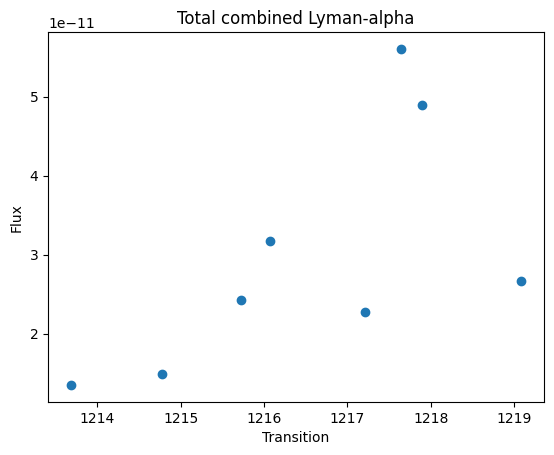

In [218]:
trans_df['transition'] = pd.Categorical(trans_df['transition'], categories=ordered_transitions, ordered=True)
trans_df = trans_df.sort_values('transition')
int_fluxes = trans_df.apply(lambda row: integrated_flux(row['coadded_velocity'].value, row['single_coadded_flux'].value), axis=1)
#plt.plot(trans_df['transition'], int_fluxes, marker='o', lw=0)
plt.plot(ordered_pump_LyA, int_fluxes, marker='o', lw=0)
plt.ylabel('Flux')
plt.xlabel('Transition')
plt.title('Total combined Lyman-alpha')
plt.show()

In [222]:
def LyA_func(x, amp1, amp2, sig1, sig2, cen1, cen2, bgl):
    y = fitting.gaussian(x, amp1, sig1, cen1, 0) + fitting.gaussian(x, amp2, sig2, cen2, 0) + bgl
    return y

#x axis is LyA pumping wavelengths

popt, pcov = curve_fit(LyA_func, ordered_pump_LyA, int_fluxes, p0 = [3.170175e-11, 5.606338e-11, 2, 1, 1216.07, 1217.64, 1e-11])

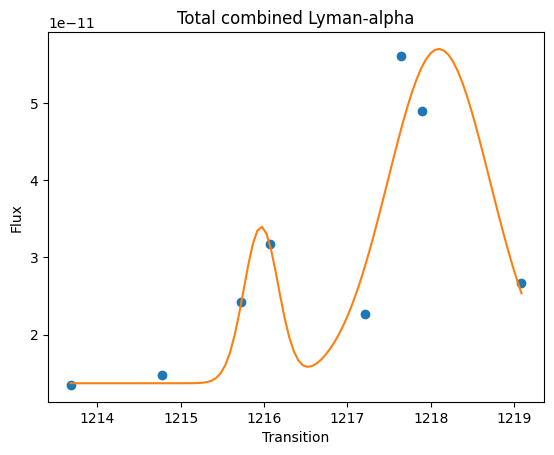

In [224]:
LyA_x = np.linspace(ordered_pump_LyA[0], ordered_pump_LyA[-1], 100)
LyA_y = LyA_func(LyA_x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6])
plt.clf()
plt.plot(ordered_pump_LyA, int_fluxes, marker='o', lw=0)
plt.ylabel('Flux')
plt.xlabel('Transition')
plt.title('Total combined Lyman-alpha')
plt.plot(LyA_x, LyA_y, label='fit')
plt.show()

# Time-series plots of parameters and integrated fluxes

In [ ]:
for transition_plot in prog_df['transition'].unique():
    mask = prog_df['transition'] == transition_plot
    x = prog_df['obsdate'][mask]
    y = int_fluxes[mask]
    plt.plot(x, y, marker='.')
    plt.ylabel('Integrated flux')
    plt.xlabel('Date')
    plt.title(transition_plot)
    plt.gca().tick_params(axis='x', labelrotation=60, labelsize=8)
    plt.show()

In [ ]:
# Initialize fit_dict
params1_keys = prog_df.iloc[0]['params1'].keys()
params2_keys = prog_df.iloc[0]['params2'].keys()

# Loop through unique transitions
for transition in prog_df['transition'].unique():
    # Filter rows for this transition
    sub_df = prog_df[prog_df['transition'] == transition]
    par_dict1 = {k: [] for k in params1_keys}
    err_dict1 = {k: [] for k in params1_keys}
    par_dict2 = {k: [] for k in params2_keys}
    err_dict2 = {k: [] for k in params2_keys}
    obsdate = sub_df['obsdate']
    # Populate with values
    for _, row in sub_df.iterrows():
        for k, (val, err) in row['params1'].items():
            par_dict1[k].append(val)
            if err == None:
                err_dict1[k].append(np.nan)
            else:
                err_dict1[k].append(err)
        for k, (val, err) in row['params2'].items():
            par_dict2[k].append(val)
            if err == None:
                err_dict2[k].append(np.nan)
            else:
                err_dict2[k].append(err)
    
    fig, ax = plt.subplots(1, len(params1_keys), figsize=(20,7), layout='constrained')
    for i, key in enumerate(params1_keys):
        ax[i].errorbar(obsdate, par_dict1[key], yerr = err_dict1[key], marker='o')
        ax[i].set_ylabel(key)
        ax[i].set_xlabel('Date')
        ax[i].tick_params(axis='x', labelrotation=60, labelsize=8)
    fig.suptitle(transition)
    fig.show()

    fig2, ax2 = plt.subplots(1, len(params2_keys), figsize=(20,7), layout='constrained')
    for i, key in enumerate(params2_keys):
        ax2[i].errorbar(obsdate, par_dict2[key], yerr = err_dict2[key], marker='o')
        ax2[i].set_ylabel(key)
        ax2[i].set_xlabel('Date')
        ax2[i].tick_params(axis='x', labelrotation=60, labelsize=8)
    fig2.suptitle(transition)
    fig2.show()

# Search for asymmetry by mirroring diff

Should reflect along the peak of flux

In [ ]:
cmap = mpl.pyplot.get_cmap('magma', lut=len(prog_df['transition'].unique()))
clrs = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    clrs.append(mpl.colors.rgb2hex(rgba))
lya_colors = dict(zip(ordered_transitions, clrs))

for date in prog_df['obsdate'].unique():
    fig, ax = plt.subplots()
    offset = 1#e-13
    prog_df['transition'] = pd.Categorical(prog_df['transition'], categories=ordered_transitions, ordered=True)
    prog_from_date = prog_df[prog_df['obsdate']==date].sort_values(by='transition', ignore_index=True)
    for i, row_mirror in prog_from_date.iterrows():
        vel_arr = row_mirror['coadded_velocity']
        flux_arr = row_mirror['single_coadded_flux']
        flux_arr = flux_arr/np.max(flux_arr) #normalize the flux array
        mirrored_vel = 2 * vel_arr[np.argmax(flux_arr)] - vel_arr #mirror the velocity array along the maximum flux value found in the center of the plot
        sorted_indices = np.argsort(mirrored_vel)
        mirrored_flux = flux_arr.copy()
        x_mirrored = mirrored_vel[sorted_indices]
        y_mirrored = mirrored_flux[sorted_indices]
        residuals_x = vel_arr
        residuals_y = flux_arr - y_mirrored
        ax.plot(residuals_x, residuals_y.value - i*offset, label=row_mirror['transition'], c=lya_colors[row_mirror['transition']])
        ax.set_xlabel('Radial Velocity'+' ('+u.format.Latex().to_string(row_mirror['coadded_velocity'].unit, fraction=False)+')')
        ax.set_ylabel('Normalized Flux'+' ('+u.format.Latex().to_string(row_mirror['single_coadded_flux'].unit, fraction=False)+')')
        ax.set_title(row_mirror['obsdate'])
    ax.legend()
    plt.show()